In [7]:
import os
import numpy as np
#import tensorflow as tf
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import tensorflow.compat.v1 as tf ###This makes it behave like TF 1.x, which has some 'stupid' commands not in 2.0 which are usefull for this project
tf.disable_v2_behavior()

In [8]:
#User Parametrer
max_its = 10000
batch   = 50
alpha   = 1e-3
r       = .05

In [9]:
#Network funcitons

#Weight Init
def weight_var(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

#Bias init
def bias_var(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

#Convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

#Pooling
def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='SAME')

In [10]:
#Load data
from keras.datasets import cifar10
(x_train, label_train), (x_test, label_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32') / 255.

y_train = np.zeros([50000,10])
y_test  = np.zeros([10000,10])
for i in range(50000):
    y_train[i,label_train[i]] = 1
    if i < 10000:
        y_test[i,label_test[i]] = 1



In [13]:
#Placeholders
x   = tf.placeholder(tf.float32, shape=[None, 32,32,3])
y_t = tf.placeholder(tf.float32, shape=[None,10])
keep_prob = tf.placeholder(tf.float32) 
filteridx = tf.placeholder(tf.int32)

In [14]:
#Initialize Variables
W_conv1 = weight_var([5, 5, 3,  32])
W_conv2 = weight_var([5, 5, 32, 32])
W_conv3 = weight_var([3, 3, 32, 64])
W_out   = weight_var([4096,10])
b_conv1 = bias_var([32,32,32])
b_conv2 = bias_var([16,16,32])
b_conv3 = bias_var([8,8,64])
b_out   = bias_var([10])

In [15]:
#Forward graph 
H1 = max_pool(tf.nn.relu(conv2d(x, W_conv1) + b_conv1)) #+ will be replace by tf.add during graph compliation
H2 = max_pool(tf.nn.relu(conv2d(H1, W_conv2) + b_conv2))
H3 = tf.nn.relu(conv2d(H2, W_conv3) + b_conv3)
H3flat = tf.reshape(H3, [-1, 8*8*64])
H3drop = tf.nn.dropout(H3flat, keep_prob)
Z  = tf.matmul(H3drop,W_out) + b_out

#Visualization stuff
V1_score = tf.reduce_mean(conv2d(x, W_conv1)[:,:,:,filteridx])
V1_grad  = tf.gradients(V1_score,x)[0]
H1_val = conv2d(x, W_conv1)[:,:,:,filteridx]


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
#Loss and Accuracy
correct_prediction = tf.equal(tf.argmax(Z,1), tf.argmax(y_t,1))
#Define accuracy over batch
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#loss
regularizer = tf.nn.l2_loss(W_out)+tf.nn.l2_loss(b_out)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z,labels=y_t)+r*regularizer)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [17]:
#Session
sess = tf.Session()
#define train method	
train_step = tf.train.AdamOptimizer(alpha).minimize(cross_entropy)
#Initiatlize and begin saver
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()



In [18]:
## train
for i in range(max_its):
    Idx = np.random.randint(1, 50000, batch)
    train_step.run(session=sess, feed_dict={x:x_train[Idx,:,:,:], y_t:y_train[Idx,:], keep_prob:.5})
    
    if i %100 == 0:
        acc, loss = sess.run([accuracy,cross_entropy], feed_dict={x:x_train[Idx,:,:,:], y_t:y_train[Idx,:], keep_prob:1})            
        print("Batch = %d, Loss: %f, Accuracy: %f" %(i+1,loss,acc))
    
    if i%1000 == 0:
        Idx = np.random.randint(1, 5000, batch)
        acc= sess.run([accuracy], feed_dict={x:x_test[Idx,:,:,:], y_t:y_test[Idx,:], keep_prob:1})            
        
   


Batch = 1, Loss: 11.706110, Accuracy: 0.160000
Batch = 101, Loss: 5.536428, Accuracy: 0.240000
Batch = 201, Loss: 3.561258, Accuracy: 0.400000
Batch = 301, Loss: 2.704759, Accuracy: 0.340000
Batch = 401, Loss: 2.390501, Accuracy: 0.360000
Batch = 501, Loss: 2.081708, Accuracy: 0.440000
Batch = 601, Loss: 1.704873, Accuracy: 0.480000
Batch = 701, Loss: 1.519307, Accuracy: 0.480000
Batch = 801, Loss: 1.403812, Accuracy: 0.560000
Batch = 901, Loss: 1.417596, Accuracy: 0.520000
Batch = 1001, Loss: 1.286500, Accuracy: 0.580000
Batch = 1101, Loss: 1.224554, Accuracy: 0.660000
Batch = 1201, Loss: 1.549978, Accuracy: 0.520000
Batch = 1301, Loss: 1.621113, Accuracy: 0.400000
Batch = 1401, Loss: 1.334311, Accuracy: 0.540000
Batch = 1501, Loss: 1.504157, Accuracy: 0.600000
Batch = 1601, Loss: 1.439551, Accuracy: 0.620000
Batch = 1701, Loss: 1.434148, Accuracy: 0.560000
Batch = 1801, Loss: 1.560928, Accuracy: 0.560000
Batch = 1901, Loss: 1.260350, Accuracy: 0.640000
Batch = 2001, Loss: 0.941720, A

In [25]:
#Test
test_size = 500
#Overall Accuracy
Overall,Zfinal = sess.run([accuracy, Z], feed_dict={x:x_test[0:test_size,:], y_t:y_test[0:test_size,:], keep_prob:1})
print("Overall Test Accuracy: %g"%(Overall))

Overall_train,Zfinal_train = sess.run([accuracy, Z], feed_dict={x:x_train[0:test_size,:], y_t:y_train[0:test_size], keep_prob:1})
print("Overall Train Accuracy: %g"%(Overall_train))

#PerClass accuracy
correct = np.zeros(10)
classcount = np.zeros(10)
for i in range(99):
    classcount[np.argmax(y_test[i,:])] = classcount[np.argmax(y_test[i,:])] + 1
    if np.argmax(Zfinal[i,:]) == np.argmax(y_test[i,:]):
        correct[np.argmax(y_test[i,:])] = correct[np.argmax(y_test[i,:])] + 1
classaccuracy = correct/classcount
print("Accuacy by class:")
print(100*classaccuracy)


Overall Test Accuracy: 0.698
Overall Train Accuracy: 0.742
Accuacy by class:
[ 80.         100.          75.          60.          28.57142857
  62.5         81.25        60.          92.30769231  81.81818182]


C:\Users\sscho\Anaconda3\envs\tf2gpu\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


Filters


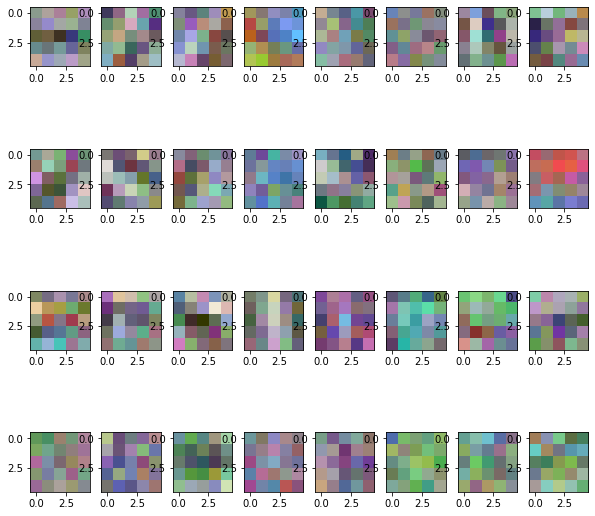

In [27]:
#Look directly at filters
plt.figure(1,figsize=(10,10))
Wval = sess.run(W_conv1)
plt.subplot(4,8,1)
Wval = Wval-np.min(Wval)
Wval = Wval/np.max(Wval)
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(Wval[:,:,:,i])
print('Filters')


Computing Visualizations for Filters


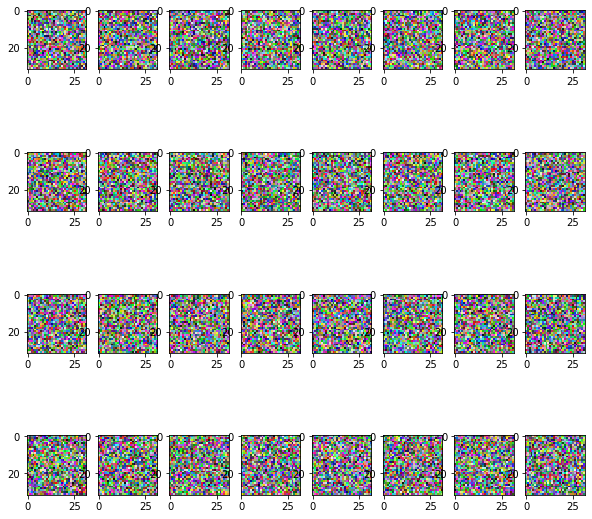

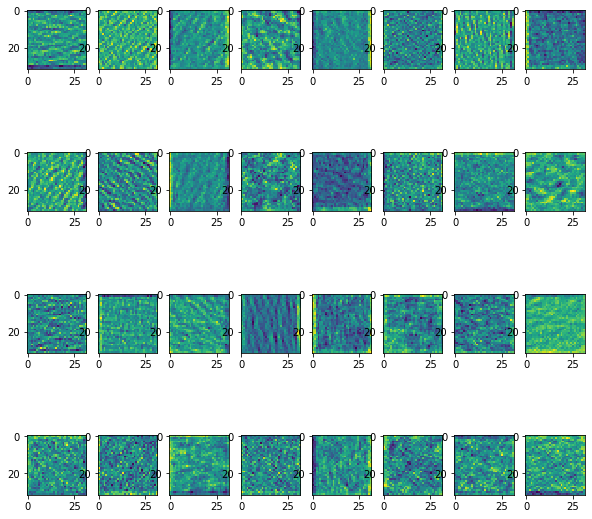

In [36]:
print("Computing Visualizations for Filters")

#Find output which maximizes filters
FinalImages = np.zeros((32,32,32))
for i in range(32):
    image1 = np.random.uniform(size =(1,32,32,3))
    image1 - np.min(image1)
    image1 = image1/np.max(image1)

    for step in range(500):	
        imageGrad1,score = sess.run([V1_grad, V1_score], feed_dict={x:image1, filteridx:i})
        
        image1 = image1 + .005*imageGrad1
        #image1 /= image1.std()
        image1 - np.min(image1)
        image1 = image1/np.max(image1)
        
        #if step %100 == 0:
        #    print("Filer: %d, Batch = %d, Filter Score: %f" %(i+1,step+1,score))#
    
    #plot
    image1 = np.maximum(image1,0)
    plt.figure(4,figsize=(10,10))
    plt.subplot(4,8,i+1)
    plt.imshow(image1[0,:,:,:])
    plt.figure(5,figsize=(10,10))
    plt.subplot(4,8,i+1)
    A = sess.run(H1_val, feed_dict={x:image1, filteridx:i})
    plt.imshow(A[0,:,:])
